In [1]:
from datasets import load_dataset

In [2]:
data = load_dataset("dair-ai/emotion", download_mode="force_redownload")
print(f"Train dataset size: {len(data['train'])}")
print(f"Test dataset size: {len(data['test'])}")

/usr/local/lib/python3.9/site-packages/datasets/load.py:1486: FutureWarning: The repository for dair-ai/emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dair-ai/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Train dataset size: 16000
Test dataset size: 2000


# Tokenization

Find the most appropriate tokenizer

- Can try both the ones found in the huggingface library and if there is time, a manual approach
- Potentially use pipeline for one model and compare another tokenizer with another model

# Modeling


In [3]:
import torch
from torch.utils.data import DataLoader
from transformers import get_scheduler, BertForSequenceClassification, BertTokenizer
from accelerate import Accelerator
import tensorflow as tf
import numpy as np
from tqdm.auto import tqdm
from torch.optim import Adam
from sklearn.metrics import accuracy_score, confusion_matrix

# BERT

### load model and tokenizer

In [4]:
BERT_model = BertForSequenceClassification.from_pretrained("bhadresh-savani/bert-base-uncased-emotion", num_labels=6)

In [5]:
BERT_model.config.id2label = {    
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"}

BERT_model.config

BertConfig {
  "_name_or_path": "bhadresh-savani/bert-base-uncased-emotion",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "transformers_version": "4.41.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [6]:
# Load tokenizer
BERT_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


In [7]:
def BERT_tokenize_function(examples):
    return BERT_tokenizer(examples["text"], padding="max_length", truncation=True)

In [8]:
BERT_tokenized_datasets = data.map(BERT_tokenize_function, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [23]:
BERT_tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [24]:
BERT_tokenizer.decode(BERT_tokenized_datasets['test']['input_ids'][0],return_tensors='pt')

'[CLS] im feeling rather rotten so im not very ambitious right now [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [18]:
from pprint import pprint
pprint(BERT_tokenized_datasets['train'][:2], compact=True, width = 110)

{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 

In [25]:
# Remove the text column because the model does not accept raw text as an input:
BERT_tokenized_datasets = BERT_tokenized_datasets.remove_columns(["text"])
# Rename the label column to labels because the model expects the argument to be named labels:
BERT_tokenized_datasets = BERT_tokenized_datasets.rename_column("label", "labels")
BERT_tokenized_datasets.set_format("torch")

# Then create a smaller subset of the dataset as previously shown to speed up the fine-tuning:
BERT_small_train_dataset = BERT_tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
BERT_small_eval_dataset = BERT_tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

In [26]:
BERT_train_dataloader = DataLoader(BERT_small_train_dataset, shuffle=True, batch_size=16)
BERT_eval_dataloader = DataLoader(BERT_small_eval_dataset, batch_size=8)

In [27]:
# the folowing params are the same as in our reference paper
batch_size = 16
num_epochs = 10
num_training_steps = num_epochs * len(BERT_train_dataloader)
total_steps = len(BERT_train_dataloader) 

optimizer = Adam(BERT_model.parameters(), lr=4e-5) #Adam optimizer
lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

In [29]:
device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
BERT_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [15]:
progress_bar = tqdm(range(num_training_steps))

BERT_model.train()
total_loss = 0
accelerator = Accelerator()

for epoch in range(num_epochs):
    
    print('-' * 20)
    print(f'Begin epoch {epoch+1}')
    print('-' * 20)
    
    for step, batch in enumerate(BERT_train_dataloader): # 63 + 1
        
        optimizer.zero_grad()       
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = BERT_model(**batch) # equivalent to model.forward(**batch)  
        
        loss = torch.nn.functional.cross_entropy(
            target=batch['labels'], input=outputs.logits, reduction='sum')
        accelerator.backward(loss)
        optimizer.step()
        lr_scheduler.step()
        
        total_loss += loss.cpu().detach().item()
        
        progress_bar.update(1)
        
        if step % 10 == 0:
            print("Total loss: ", total_loss)
            print(f'[{100 * step/total_steps:.3f}%] Step {step}/{total_steps}.\
                Average Loss: {total_loss/((batch_size*(step+1) + (epoch)*1000)):.6f}')

    print('-' * 20)
    print(f'End of epoch {epoch+1}')
    print('-' * 20)
    print(f'Total epoch loss: {total_loss:.2f} \
        (Average Loss: {total_loss / ((epoch+1)*1000):.6f})')        
    print("\n\n")

  0%|          | 0/630 [00:00<?, ?it/s]

--------------------
Begin epoch 1
--------------------
Total loss:  1.4173022508621216
[0.000%] Step 0/63.                Average Loss: 0.088581
Total loss:  34.897502951323986
[15.873%] Step 10/63.                Average Loss: 0.198281
Total loss:  62.956431083381176
[31.746%] Step 20/63.                Average Loss: 0.187370
Total loss:  80.80865512788296
[47.619%] Step 30/63.                Average Loss: 0.162921
Total loss:  105.70353692770004
[63.492%] Step 40/63.                Average Loss: 0.161133
Total loss:  129.9769090116024
[79.365%] Step 50/63.                Average Loss: 0.159285
Total loss:  153.81895458698273
[95.238%] Step 60/63.                Average Loss: 0.157601
--------------------
End of epoch 1
--------------------
Total epoch loss: 158.20         (Average Loss: 0.158202)



--------------------
Begin epoch 2
--------------------
Total loss:  158.64028844237328
[0.000%] Step 0/63.                Average Loss: 0.156142
Total loss:  166.98889103531837
[15.873%

In [16]:
BERT_model.save_pretrained('fine-tuned_BERT')

## evaluate

In [32]:
BERT_model = BertForSequenceClassification.from_pretrained('fine-tuned_BERT')
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
BERT_model.to(device) # mps

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [33]:
progress_bar = tqdm(range(len(BERT_eval_dataloader)))

BERT_model.eval()
predictions = []
true_labels = []

for batch in BERT_eval_dataloader:
       
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = BERT_model(**batch, return_dict=True) # equivalent to model.forward(inputs)  

    logits = outputs.logits
    predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()
    
    predictions.extend(predicted_labels)
    true_labels.extend(batch['labels'].cpu().numpy())
    
    
    progress_bar.update(1)

  0%|          | 0/125 [00:00<?, ?it/s]

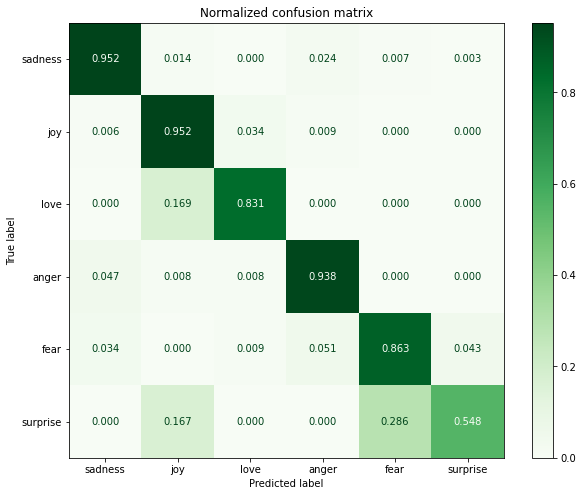

Accuracy: 0.914


In [73]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = BERT_model.config.id2label.values()
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Greens", values_format=".3f", ax=ax)
    plt.title("Normalized confusion matrix")
    plt.show()
    
plot_confusion_matrix(true_labels, predictions, labels)
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy}')

In [48]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predictions, digits = 4, target_names=labels)

              precision    recall  f1-score   support

     sadness     0.9516    0.9582    0.9549       287
         joy     0.9517    0.9331    0.9423       359
        love     0.8310    0.8082    0.8194        73
       anger     0.9380    0.8832    0.9098       137
        fear     0.8632    0.8783    0.8707       115
    surprise     0.5476    0.7931    0.6479        29

    accuracy                         0.9140      1000
   macro avg     0.8472    0.8757    0.8575      1000
weighted avg     0.9191    0.9140    0.9157      1000

